In [98]:
import networkx as nx
import glob
import os
import matplotlib.pyplot as mpl
import seaborn as sns
import pandas as pd
import copy

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

In [99]:
# %matplotlib inline

In [100]:
# G = nx.read_gpickle("newdata/20171201/kegg_reaction_compound_graph_with_attributes.pkl")#SAFR-032_reaction_compound_graph_with_attributes.pkl")
G = nx.read_gpickle("newdata/20171201/SAFR-032_reaction_compound_graph_with_attributes.pkl")


In [101]:
# G.nodes['C00223']['pathways']

#### Add `bipartite` attribute to the nodes (for compounds `bipartite = 0`, for reactions `bipartite = 1`)

In [102]:
# G.nodes()

In [103]:
len(list(G.nodes()))

2746

In [104]:
r_nodes = [n for n in list(G.nodes()) if n.startswith("R")]

In [105]:
c_nodes = [n for n in list(G.nodes()) if n.startswith("C")]

In [106]:
len(r_nodes)

1325

In [107]:
len(c_nodes)

1421

In [108]:
bipartite_label = dict()
for c in c_nodes:
    bipartite_label[c] = {"bipartite":0}
    
for r in r_nodes:
    bipartite_label[r] = {"bipartite":1}

    # bipartite_0_nodes = {0: {'attr1': 20, 'attr2': 'nothing'}, 1: {'attr2': 3}}

In [109]:
## Sets the bipartite attribute
nx.set_node_attributes(G, bipartite_label)

In [110]:
# nx.get_node_attributes(G,"bipartite")

In [111]:
compound_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
reaction_nodes = set(G) - compound_nodes

In [112]:
len(compound_nodes)

1421

In [113]:
len(reaction_nodes)

1325

In [114]:
nx.bipartite.is_bipartite_node_set(G,compound_nodes)

True

#### Find compounds ids which are not in the compound database (and thus have no compound json)

In [115]:
def identify_compounds_which_are_not_in_compound_database(G):
    substrates = nx.get_node_attributes(G,"substrates")
    products = nx.get_node_attributes(G,"products")
    reactions = nx.get_node_attributes(G,"reactions")
    
    c_ids_in_substrates_or_products = set()
    for s in substrates:
        c_ids_in_substrates_or_products.update(set(substrates[s]))
    for p in products:
        c_ids_in_substrates_or_products.update(set(products[p]))
        
    return c_ids_in_substrates_or_products - set(reactions)

In [116]:
compounds_not_in_database = identify_compounds_which_are_not_in_compound_database(G)

In [117]:
def identify_reactions_which_have_compounds_not_in_database(G,compounds_not_in_database):
    # find all reactions which list a compound which is not present in the compound database
    substrates = nx.get_node_attributes(G,"substrates")
    products = nx.get_node_attributes(G,"products")
    reactions = nx.get_node_attributes(G,"reactions")
    
    faulty_reactions = []
    
    for r in substrates:
        if bool(compounds_not_in_database & set(substrates[r])):
            faulty_reactions.append(r)
    for r in products:
        if bool(compounds_not_in_database & set(products[r])):
            faulty_reactions.append(r)
            
    return faulty_reactions

In [118]:
reactions_to_remove = identify_reactions_which_have_compounds_not_in_database(G,compounds_not_in_database)

#### Find reaction ids which are not in the reaction database (and thus have no reaction json)
#### This section doesn't do anything, but it's good to know

In [120]:
# nx.get_node_attributes(G,"substrates")

In [121]:
substrates = nx.get_node_attributes(G,"substrates")
products = nx.get_node_attributes(G,"products")
reactions = nx.get_node_attributes(G,"reactions")

r_ids_in_reactions = set()
for c in reactions:
    r_ids_in_reactions.update(set(reactions[c]))

In [122]:
len(r_ids_in_reactions)

9361

In [123]:
r_in_sub_prod_dicts = set(substrates) & set(products)

In [124]:
len(r_in_sub_prod_dicts)

1325

In [125]:
len(r_ids_in_reactions - r_in_sub_prod_dicts) 

##This list appears to be full of reactions which have glycans. Did I get rid of them here?
## No, they are removed in the "advance_expansion_1_generation" function

8036

In [126]:
# r_ids_in_reactions - r_in_sub_prod_dicts

In [127]:
len(r_in_sub_prod_dicts - r_ids_in_reactions)

0

In [128]:
len(reactions)

1421

In [129]:
icount = 0
for i in reactions:
    print i
    icount+=1
    if icount ==5: break

C01028
C01024
C04501
C04877
C04874


In [130]:
'C14819' in list(reactions)

False

In [131]:
'C16471' in list(reactions)

True

In [132]:
ds80_seeds = ['C00011',
'C20298',
'C14819',
'C00087',
'C00237',
'C00058',
'C00033',
'C00031',
'C00095',
'C00124',
'C00159',
'C00243',
'C00208',
'C00282',
'C00007',
'C00001']


In [133]:
for c in ds80_seeds:
    if c not in list(reactions):
        print c

C20298
C14819
C00208
C00282


Arsenic,
Iron,
Manose,
are not in DS-80's reactions. 

#### Remove reactions which contain compounds that don't exist

In [134]:
# G['R11803']

In [135]:
G.remove_nodes_from(reactions_to_remove)

### These reactions are now removed

In [136]:
# G['R11803']

### Create generations of networks starting from glucose

In [151]:
def advance_expansion_1_generation(G,current_compounds,current_reactions):

    reactions = nx.get_node_attributes(G,"reactions") # this dict has compounds only
    substrates = nx.get_node_attributes(G,"substrates") # this dict has reactions only
    products = nx.get_node_attributes(G,"products") # this dict has reactions only

    verified_compounds = set()
    verified_reactions = set()
    
    all_potential_reactions = set([r for c in current_compounds for r in reactions[c] if r in substrates]) #this gets rid of glycans
    print all_potential_reactions
    unverified_reactions = all_potential_reactions - current_reactions

    for r in unverified_reactions:
        if set(products[r]+substrates[r]).issubset(current_compounds):
            verified_reactions.add(r)
            # already have all compounds
        elif set(substrates[r]).issubset(current_compounds):
            verified_compounds.update(set(products[r]))
            verified_reactions.add(r)
        elif set(products[r]).issubset(current_compounds):
            verified_compounds.update(set(substrates[r]))
            verified_reactions.add(r)
            
    verified_new_compounds = verified_compounds - current_compounds
    verified_new_reactions = verified_reactions - current_reactions
                
    return verified_new_compounds,verified_new_reactions

In [138]:
def advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag):
    all_compounds = copy.copy(seed_compounds)
    all_reactions = set()
    
    verified_new_compounds = copy.copy(seed_compounds) # anything not length 0
    
#     gen_by_gen = dict()
#     added_per_gen = dict()
    
    list_of_dicts = list()
    
    generation = 0
    while len(verified_new_compounds) != 0:
        ## verified new reactions are @ t-1, verified new compounds are @ t
        verified_old_compounds = copy.copy(verified_new_compounds)
        verified_new_compounds,verified_new_reactions = advance_expansion_1_generation(G,all_compounds,all_reactions)
        
        all_reactions.update(verified_new_reactions)
        
#         gen_by_gen[generation] = {"n_reactions":len(all_reactions),"n_compounds":len(all_compounds)}
#         added_per_gen[generation] = {"n_reactions":len(verified_new_reactions),"n_compounds":len(verified_old_compounds)}
        
        big_dict = dict()
        ## Non network properites
        big_dict['generation'] = generation
        big_dict['n_compounds_new'] = len(verified_old_compounds)
        big_dict['n_reactions_new'] = len(verified_new_reactions)
        big_dict['n_compounds_cumulative'] = len(all_compounds)
        big_dict['n_reactions_cumulative'] = len(all_reactions)
        big_dict['compounds_new'] = list(verified_old_compounds)
        big_dict['reactions_new'] = list(verified_new_reactions)
        big_dict['seed'] = list(seed_compounds)
        
        ## Network properties
        subgraph_nodes = all_compounds | all_reactions ## union of sets
        subG = G.subgraph(subgraph_nodes)
        
#         big_dict['bipartite_avg_clustering'] = nx.bipartite.average_clustering(subG)
#         big_dict['bipartite_avg_clustering_compounds'] = nx.bipartite.average_clustering(subG,all_compounds)
#         big_dict['bipartite_avg_clustering_reactions'] = nx.bipartite.average_clustering(subG,all_reactions)
        
        ## Betweeness centrality        
#         betweenness_dict = nx.bipartite.betweenness_centrality(subG, all_compounds)
        
#         c_betweenness_dict = dict((k, betweenness_dict[k]) for k in all_compounds if k in betweenness_dict)
#         r_betweenness_dict = dict((k, betweenness_dict[k]) for k in all_reactions if k in betweenness_dict)
        
#         big_dict['bipartite_avg_betweenness_compounds'] = sum(c_betweenness_dict.values())/float(len(c_betweenness_dict))
#         big_dict['bipartite_avg_betweenness_reactions'] = sum(r_betweenness_dict.values())/float(len(r_betweenness_dict))
        
        ## Degree
        r_degs,c_degs = nx.bipartite.degrees(subG,all_compounds)
        
#         big_dict['bipartite_avg_deg_compounds'] = sum([i[1] for i in c_degs])/float(len(c_degs))
#         big_dict['bipartite_avg_deg_reactions'] = sum([i[1] for i in r_degs])/float(len(r_degs))
        
        ## Tagged compounds
        current_tags = list()
        for k in compounds_to_tag:
            if k in verified_old_compounds:
                current_tags.append(compounds_to_tag[k])
        if len(current_tags)==0:
            big_dict['tags'] = None
        else:
            big_dict['tags'] = str(current_tags)
        
        print generation
        
        list_of_dicts.append(big_dict)
        
        generation+=1
        
        all_compounds.update(verified_new_compounds)
        
    return list_of_dicts
        

### Run through multiple seed sets

In [139]:
# seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
# big_dict = advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag)

In [140]:
# all_seeds = {'Glucose':set(["C00001","C00031"]),
#              'ATP':set(["C00001","C00002"]),
#              'CoA':set(["C00001","C00010"]),
#              'CO2,NH3,H3PO4,H2SO4':set(["C00001","C00011","C00014","C00009","C00059"])}

# all_seeds = {'CO2_H2_S':set(["C00001","C00011","C00282","C00087"]),
#              'Maltose_O2':set(["C00001","C00208","C00007"])}
# #             'Formate_Fe3':set(["C00001","C00058","C14819"]),

## Goldford = Water, CO2, HCO3, H2S, NH3, N2, Formate, Acetate

## Enceladus from row 20 in spreadsheet 
# Water (H2O), 
# Carbon Dioxide (CO2), 
# Carbon Monoxide (CO), 
# Hydrogen (H2), 
# Formaldehyde (H2CO), 
# Methanol (CH3OH), 
# Ethylene oxide (C2H4O), 
# Ethanol (C2H6O), 
# Hydrogen sulfide (H2S), 
# Argon (40Ar), NOT IN KEGG
# Ammonia (NH3), 
# Nitrogen (N2), 
# Hydrogen Cyanid (HCN), 
# Methane (CH4), 
# Acetylene (C2H2), 
# Ethylene (C2H4), 
# Ethane (C2H6), NOT IN KEGG
# Propyne (C3H4), NOT IN KEGG
# Propene (C3H6), 
# Propane (C3H8), 
# Diacetylene (C4H2), NOT IN KEGG
# Cyclobutadiene (C4H4), NOT IN KEGG
# 1-Butyne (C4H6), NOT IN KEGG
# 2-Butene (C4H8), NOT IN KEGG
# Butane (C4H10), NOT IN KEGG
# Cyclopentadiene (C5H6), NOT IN KEGG
# Pentane (C5H12), NOT IN KEGG
# Benzene (C6H6)

## Overlap: Water, CO2, H2S, NH3, N2
## No overlap: Formate, Acetate, HCO3

all_seeds = {"Goldford-SAFR-032": set(["C00001","C00011","C00288","C00283","C00014","C00697","C00058","C00033"]),
             "Enceladus_20-SAFR-032": set(["C00001","C00011","C00237","C00282","C00067","C00132","C06548","C00469",
                                      "C00283","C00014","C00697","C01326","C01438","C01548","C06547","C11505",
                                      "C20783","C01407"])}

# all_seeds = {"CO2 H2  S":set(["C00011","C00282","C00087"]),
# "CO  H2  S":set(["C00237","C00282","C00087"]),
# "CO  H2  S":set(["C00237","C00282","C00087"]),
# "Formate H2  S":set(["C00058","C00282","C00087"]),
# "Acetate H2  S":set(["C00033","C00282","C00087"]),
# "Glucose H2  S":set(["C00031","C00282","C00087"]),
# "Fructose    H2  S":set(["C00095","C00282","C00087"]),
# "Galactose   H2  S":set(["C00124","C00282","C00087"]),
# "Mannose H2  S":set(["C00159","C00282","C00087"]),
# "Lactose H2  S":set(["C00243","C00282","C00087"]),
# "Maltose H2  S":set(["C00208","C00282","C00087"]),
# "CO2 H2  Fe3+":set(["C00011","C00282","C14819"]),
# "CO  H2  Fe3+":set(["C00237","C00282","C14819"]),
# "Formate H2  Fe3+":set(["C00058","C00282","C14819"]),
# "Acetate H2  Fe3+":set(["C00033","C00282","C14819"]),
# "Glucose H2  Fe3+":set(["C00031","C00282","C14819"]),
# "Fructose    H2  Fe3+":set(["C00095","C00282","C14819"]),
# "Galactose   H2  Fe3+":set(["C00124","C00282","C14819"]),
# "Mannose H2  Fe3+":set(["C00159","C00282","C14819"]),
# "Lactose H2  Fe3+":set(["C00243","C00282","C14819"]),
# "Maltose H2  Fe3+":set(["C00208","C00282","C14819"]),
# "CO  CO  Fe3+":set(["C00237","C00237","C14819"]),
# "Formate Formate Fe3+":set(["C00058","C00058","C14819"]),
# "Acetate Acetate Fe3+":set(["C00033","C00033","C14819"]),
# "Glucose Glucose Fe3+":set(["C00031","C00031","C14819"]),
# "Fructose    Fructose    Fe3+":set(["C00095","C00095","C14819"]),
# "Galactose   Galactose   Fe3+":set(["C00124","C00124","C14819"]),
# "Mannose Mannose Fe3+":set(["C00159","C00159","C14819"]),
# "Lactose Lactose Fe3+":set(["C00243","C00243","C14819"]),
# "Maltose Maltose Fe3+":set(["C00208","C00208","C14819"]),
# "Formate Formate O2":set(["C00058","C00058","C00007"]),
# "Acetate Acetate O2":set(["C00033","C00033","C00007"]),
# "Glucose Glucose O2":set(["C00031","C00031","C00007"]),
# "Fructose    Fructose    O2":set(["C00095","C00095","C00007"]),
# "Galactose   Galactose   O2":set(["C00124","C00124","C00007"]),
# "Mannose Mannose O2":set(["C00159","C00159","C00007"]),
# "Lactose Lactose O2":set(["C00243","C00243","C00007"]),
# "Maltose Maltose O2":set(["C00208","C00208","C00007"]),
# "CO2 S  S":set(["C00011","C00087","C00087"]),
# "CO2 S  Fe3+":set(["C00011","C00087","C14819"]),
# "CO2 As3+    O2":set(["C00011","C20298","C00007"]),
# "CO2 As3+    Fe3+":set(["C00011","C20298","C14819"])}

In [150]:
# r_nodes

In [141]:
compounds_to_tag = {"C00003":'NAD',
                   "C00031":'Glucose',
                   "C00288":'HCO3',
                   "C00058":'Formate',
                   "C00033":'Acetate',
                   "C00007":'O2'}
# compounds_to_tag = {"C00003":'NAD',
#                    "C00006":'NADP',
#                    "C00002":'ATP',
#                    "C00031":'Glucose',
#                    "C00010":'CoA'}

## Testing

In [164]:

current_compounds = all_seeds["Enceladus_20-SAFR-032"]
print current_compounds

reactions = nx.get_node_attributes(G,"reactions") # this dict has compounds only
substrates = nx.get_node_attributes(G,"substrates") # this dict has reactions only
products = nx.get_node_attributes(G,"products") # this dict has reactions only

verified_compounds = set()
verified_reactions = set()

all_potential_reactions = set()
for c in current_compounds:
    print c
    if c in reactions:
        for r in reactions[c]:
            if r in substrates:
                
                all_potential_reactions.add(r)
                
for r in all_potential_reactions:
    if set(products[r]+substrates[r]).issubset(current_compounds):
        verified_reactions.add(r)
        # already have all compounds
    elif set(substrates[r]).issubset(current_compounds):
        verified_compounds.update(set(products[r]))
        verified_reactions.add(r)
    elif set(products[r]).issubset(current_compounds):
        verified_compounds.update(set(substrates[r]))
        verified_reactions.add(r)

verified_new_compounds = verified_compounds - current_compounds
    
#     print "-"*10
# all_potential_reactions = set([r for c in current_compounds for r in reactions[c] if r in substrates])

set(['C00011', 'C01407', 'C00014', 'C00283', 'C00282', 'C06548', 'C01438', 'C00697', 'C06547', 'C00132', 'C00067', 'C11505', 'C01548', 'C00469', 'C00001', 'C20783', 'C01326', 'C00237'])
C00011
C01407
C00014
C00283
C00282
C06548
C01438
C00697
C06547
C00132
C00067
C11505
C01548
C00469
C00001
C20783
C01326
C00237


NameError: name 'unverified_reactions' is not defined

### If network expansions not stored already, run them

### Write dfs to file if you just ran the analysis

In [152]:
all_seed_dicts = dict()
for k in all_seeds:
    try:
        result_list_of_dicts = advance_expansion_to_complete_scope(G,all_seeds[k],compounds_to_tag)
        all_seed_dicts[k] = result_list_of_dicts
    except:
        print "%s failed"%k

Enceladus_20-SAFR-032 failed
Goldford-SAFR-032 failed


In [75]:
def write_dfs_to_file(dirname,all_seed_dicts):
    all_seed_dfs = dict()
    
    for seed in all_seed_dicts:
        all_seed_dfs[seed] = pd.DataFrame(all_seed_dicts[seed])
    
    for seed in all_seed_dfs:
        pathname = dirname+seed.replace(',', '_')
        all_seed_dfs[seed].to_json(pathname)

In [76]:
dirname = 'results_GvE20/'
write_dfs_to_file(dirname,all_seed_dicts)

### Otherwise read them from file

In [77]:
def read_dfs_from_file(dirname):
    all_seed_dfs = dict()
    for fname in glob.glob(dirname+'*'):
        seed = fname.split('/')[1]
        all_seed_dfs[seed] = pd.read_json(fname)
    
    return all_seed_dfs

In [78]:
dirname = 'results_GvE20/'
all_seed_dfs = read_dfs_from_file(dirname)

In [79]:
for seed_set in all_seed_dfs:
    print seed_set

Enceladus_20
Goldford


### Plot all seed sets on same plot (compounds)

In [80]:
def super_plot(all_seed_dfs,y):
    # Create traces
    traces = list()
    for seed_set in all_seed_dfs:
        _df = all_seed_dfs[seed_set].sort_index()
        _trace = go.Scatter(
        x = _df.index,
        y = _df[y],
        mode = 'lines+markers',#lines+markers+text',
        name = seed_set,
        text=_df['tags'],
        textposition='top center'
    #     text= data['state']
        )
        traces.append(_trace)
    
#     trace0 = go.Scatter(
#         x = df.index,
#         y = df[line1],
#         mode = 'lines+markers+text',
#         name = line1,
#         text=df['tags'],
#         textposition='top'
#     #     text= data['state']
#     )
#     trace1 = go.Scatter(
#         x = df.index,
#         y = df[line2],
#         mode = 'lines+markers',
#         name = line2
#     )

#     data = [trace0,trace1]
    plotly.offline.iplot(traces)

In [81]:
def super_plot_electron_acceptor(all_seed_dfs,y):
    # Create traces
    traces = list()
    for seed_set in all_seed_dfs:
        _df = all_seed_dfs[seed_set].sort_index()
        
        if "S" in seed_set and "Fe3" in seed_set:
            color = '#800080'#'purple'
        elif "S" in seed_set:
            color = '#0000FF'#'blue'
        elif "Fe3" in seed_set:
            color = '#FF0000'#'red'
        elif " O2" in seed_set:
            color = '#808000'#'yellow'
        
        _trace = go.Scatter(
        x = _df.index,
        y = _df[y],
        mode = 'lines+markers',#lines+markers+text',
        name = seed_set,
        text=_df['tags'],
        textposition='top center',
        marker = dict(
        color = color #rgba(152, 0, 0, .8)',
#         line = dict(
#             color = 'rgb(0, 0, 0)'
#     #     text= data['state']
#                 )
            )
        )
            
        traces.append(_trace)
    
#     trace0 = go.Scatter(
#         x = df.index,
#         y = df[line1],
#         mode = 'lines+markers+text',
#         name = line1,
#         text=df['tags'],
#         textposition='top'
#     #     text= data['state']
#     )
#     trace1 = go.Scatter(
#         x = df.index,
#         y = df[line2],
#         mode = 'lines+markers',
#         name = line2
#     )

#     data = [trace0,trace1]
    plotly.offline.iplot(traces)

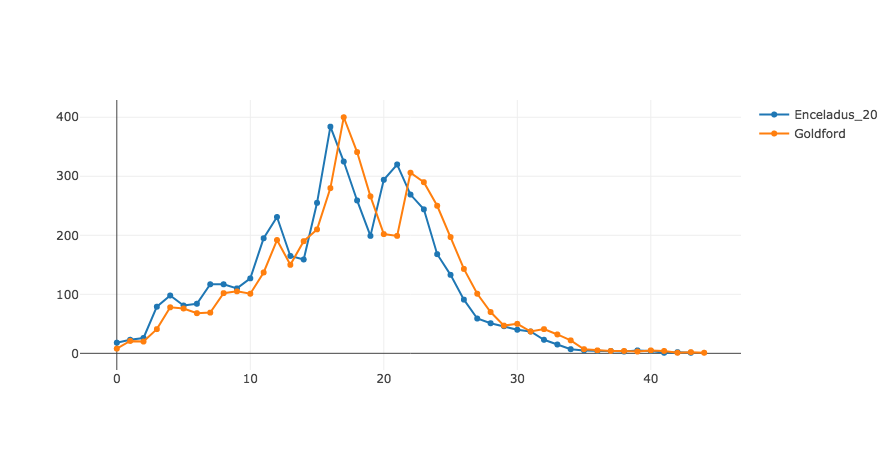

In [82]:
super_plot(all_seed_dfs,'n_compounds_new')

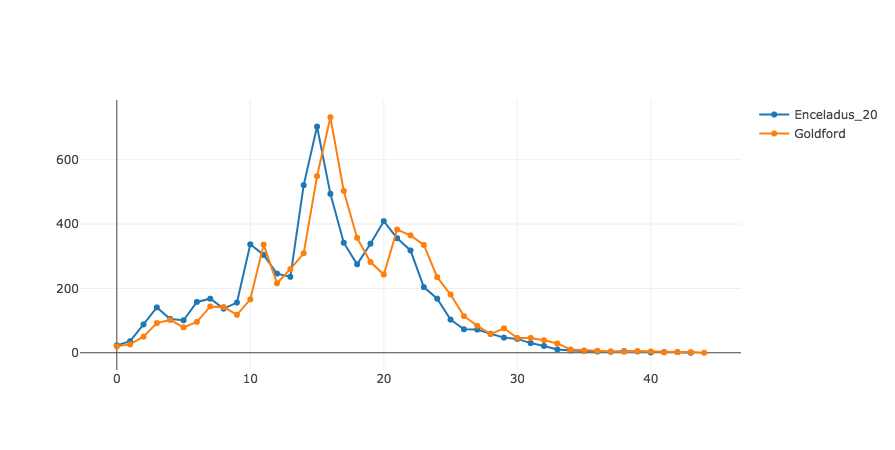

In [83]:
super_plot(all_seed_dfs,'n_reactions_new')

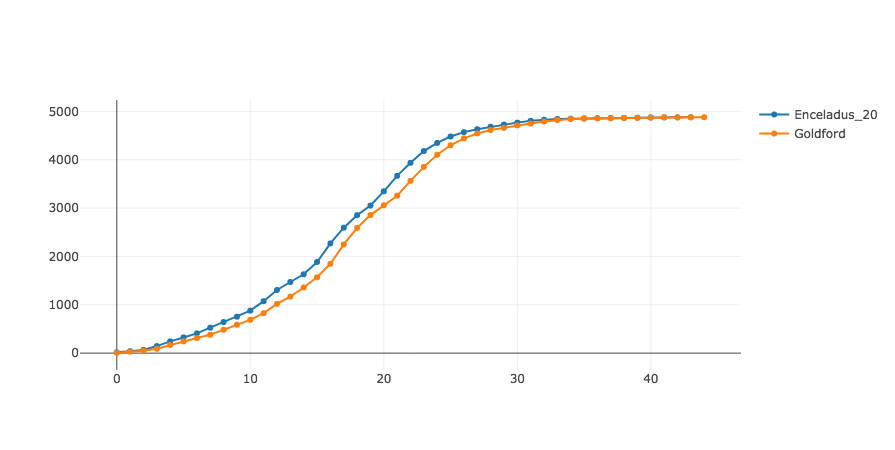

In [84]:
super_plot(all_seed_dfs,'n_compounds_cumulative')

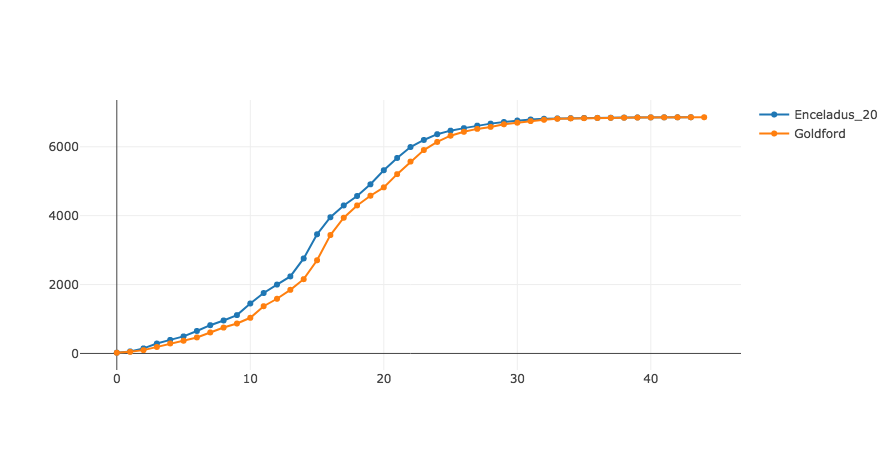

In [85]:
super_plot(all_seed_dfs,'n_reactions_cumulative')

In [86]:
all_seed_dfs['Goldford']#['n_reactions_cumulative']

,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,"[C00011, C00014, C00033, C00283, C00288, C0000...",0,8,8,20,20,"[R09483, R10079, R00522, R00152, R00153, R0553...","[C00011, C00014, C00033, C00283, C00288, C0000...","['Acetate', 'HCO3', 'Formate']"
1,"[C00007, C05361, C19033, C05359, C01010, C0038...",1,29,21,46,26,"[R10534, R01450, R04782, R03546, R07629, R0915...","[C00011, C00014, C00033, C00283, C00288, C0000...",['O2']
10,"[C05528, C17205, C00020, C02247, C01861, C0280...",10,689,101,1035,166,"[R02972, R02973, R06633, R06635, R06634, R0141...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
11,"[C05993, C05526, C01102, C03939, C00431, C0062...",11,826,137,1371,336,"[R10463, R01686, R00480, R02971, R03870, R0141...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
12,"[C18327, C00021, C20440, C03872, C06728, C2056...",12,1018,192,1587,216,"[R01416, R01417, R10466, R01144, R01145, R1156...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
13,"[C16471, C18326, C17366, C18911, C05998, C0110...",13,1168,150,1847,260,"[R10461, R08503, R09272, R01140, R00574, R0743...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
14,"[C17367, C21068, C01101, C00941, C01726, C0292...",14,1358,190,2156,309,"[R10462, R04890, R07127, R09495, R08617, R0459...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
15,"[C18325, C00791, C14899, C05856, C06520, C0002...",15,1568,210,2705,549,"[R00094, R00093, R09051, R09052, R00090, R1077...","[C00011, C00014, C00033, C00283, C00288, C0000...","['Glucose', 'NAD']"
16,"[C00140, C00394, C01455, C01029, C04390, C0175...",16,1848,280,3437,732,"[R10673, R04088, R04085, R06807, R02527, R0144...","[C00011, C00014, C00033, C00283, C00288, C0000...",None
17,"[C06720, C06727, C18910, C02804, C05853, C0599...",17,2248,400,3940,503,"[R10779, R06637, R10670, R11068, R06804, R0929...","[C00011, C00014, C00033, C00283, C00288, C0000...",None


In [87]:
all_seed_dfs['Enceladus_20']#['n_reactions_cumulative']

,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,"[C00011, C01407, C00014, C00283, C00282, C0654...",0,18,18,23,23,"[R10535, R09139, R05380, R10538, R09094, R0915...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
1,"[C00027, C00026, C00007, C00288, C05361, C0008...",1,41,23,59,36,"[R01410, R10534, R05563, R00250, R04782, R0354...","[C00011, C01407, C00014, C00283, C00282, C0654...","['O2', 'HCO3', 'Formate']"
10,"[C05682, C00588, C01197, C05993, C00346, C2065...",10,880,127,1450,337,"[R10463, R05388, R06633, R02971, R03870, R0141...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
11,"[C18327, C00021, C20440, C05683, C06728, C2056...",11,1075,195,1754,304,"[R02143, R04420, R09495, R04084, R10777, R0402...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
12,"[C16471, C18326, C18911, C06521, C05998, C0110...",12,1306,231,2000,246,"[R01140, R04890, R09050, R09052, R07262, R0978...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
13,"[C18325, C21460, C20560, C21068, C01101, C1640...",13,1471,165,2236,236,"[R04591, R10462, R08617, R05130, R03920, R0513...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
14,"[C14899, C05856, C06520, C00029, C20567, C0439...",14,1630,159,2757,521,"[R00094, R00093, R09051, R00091, R00090, R1077...","[C00011, C01407, C00014, C00283, C00282, C0654...","['Glucose', 'NAD']"
15,"[C10865, C19631, C00140, C20566, C13378, C0652...",15,1885,255,3460,703,"[R10673, R04088, R04085, R06807, R02527, R0144...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
16,"[C06720, C06727, C18910, C02804, C05853, C0599...",16,2269,384,3954,494,"[R10779, R06637, R10670, R11068, R06804, R0929...","[C00011, C01407, C00014, C00283, C00282, C0654...",None
17,"[C16472, C06729, C00141, C10906, C10107, C0463...",17,2594,325,4296,342,"[R00095, R06802, R06801, R05305, R06805, R0680...","[C00011, C01407, C00014, C00283, C00282, C0654...",None


### Colored by electron acceptor

In [61]:
# super_plot_electron_acceptor(all_seed_dfs,'n_compounds_new')

In [62]:
# super_plot_electron_acceptor(all_seed_dfs,'n_reactions_new')

In [63]:
# super_plot_electron_acceptor(all_seed_dfs,'n_compounds_cumulative')

In [64]:
# super_plot_electron_acceptor(all_seed_dfs,'n_reactions_cumulative')

In [60]:
all_seed_dfs['Mannose H2  S']#['n_reactions_cumulative']

,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,"[C00159, C00087, C00282]",0,3,3,4,4,"[R10809, R01332, R00067, R00877]","[C00159, C00087, C00282]",None
1,"[C01728, C00080, C02492, C00095, C00001, C05359]",1,9,6,8,4,"[R00878, R00307, R10817, R08612]","[C00159, C00087, C00282]",None
10,"[C00149, C00007, C00682, C05375, C01108, C0261...",10,121,32,186,47,"[R11620, R04089, R01324, R01325, R01082, R0254...","[C00159, C00087, C00282]",None
11,"[C00027, C01146, C00283, C00122, C16348, C0116...",11,155,34,222,36,"[R10535, R10538, R03127, R11352, R11351, R0005...","[C00159, C00087, C00282]",None
12,"[C14448, C00124, C00320, C05527, C15499, C0251...",12,187,32,262,40,"[R01678, R06788, R01329, R11075, R00409, R0549...","[C00159, C00087, C00282]",None
13,"[C17205, C21088, C21632, C01861, C05400, C0540...",13,219,32,281,19,"[R02991, R10846, R10135, R09784, R02410, R0918...","[C00159, C00087, C00282]",None
14,"[C20366, C12836, C08242, C21091, C04225, C0002...",14,235,16,294,13,"[R00268, R11593, R02522, R07686, R03032, R0047...","[C00159, C00087, C00282]",None
15,"[C00502, C00545, C05585, C00530, C03217, C0108...",15,247,12,306,12,"[R02520, R01645, R01647, R02714, R11263, R0524...","[C00159, C00087, C00282]",None
16,"[C13636, C01114, C02266, C06201, C05601, C0660...",16,258,11,315,9,"[R04895, R06854, R07684, R02715, R02521, R0251...","[C00159, C00087, C00282]",None
17,"[C01179, C16196, C06316, C07103, C05600, C0103...",17,265,7,328,13,"[R05388, R06632, R04380, R07683, R07682, R0685...","[C00159, C00087, C00282]",None


In [61]:
all_seed_dfs['Mannose H2  S'].sort_index()

,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,"[C00159, C00087, C00282]",0,3,3,4,4,"[R10809, R01332, R00067, R00877]","[C00159, C00087, C00282]",None
1,"[C01728, C00080, C02492, C00095, C00001, C05359]",1,9,6,8,4,"[R00878, R00307, R10817, R08612]","[C00159, C00087, C00282]",None
2,"[C06468, C00267, C17207, C00031]",2,13,4,16,8,"[R00801, R00028, R00010, R01602, R00874, R0861...","[C00159, C00087, C00282]",['Glucose']
3,"[C00252, C00221, C00208, C00089, C00794, C0108...",3,21,8,33,17,"[R00026, R09995, R01444, R11788, R02887, R0001...","[C00159, C00087, C00282]",None
4,"[C02336, C06219, C00372, C01742, C01898, C0193...",4,34,13,49,16,"[R11789, R01823, R01538, R02112, R02110, R0182...","[C00159, C00087, C00282]",None
5,"[C00973, C00204, C00721, C02013, C06400]",5,39,5,54,5,"[R05606, R08570, R01540, R01791, R03802]","[C00159, C00087, C00282]",None
6,"[C00577, C00022, C06218, C00514, C00817]",6,44,5,60,6,"[R00006, R00008, R00224, R00226, R05142, R10616]","[C00159, C00087, C00282]",None
7,"[C00011, C00084, C06033, C06010, C06217, C0090...",7,51,7,79,19,"[R02948, R00750, R00217, R05539, R05380, R0303...","[C00159, C00087, C00282]",None
8,"[C00036, C04181, C00288, C03589, C06035, C1824...",8,69,18,101,22,"[R03896, R00522, R00340, R09150, R09157, R0422...","[C00159, C00087, C00282]",None
9,"[C00033, C00596, C00898, C00804, C00090, C0222...",9,89,20,139,38,"[R01447, R05138, R03898, R03897, R00822, R0082...","[C00159, C00087, C00282]",None


### Create plots of the different seed set data

In [93]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

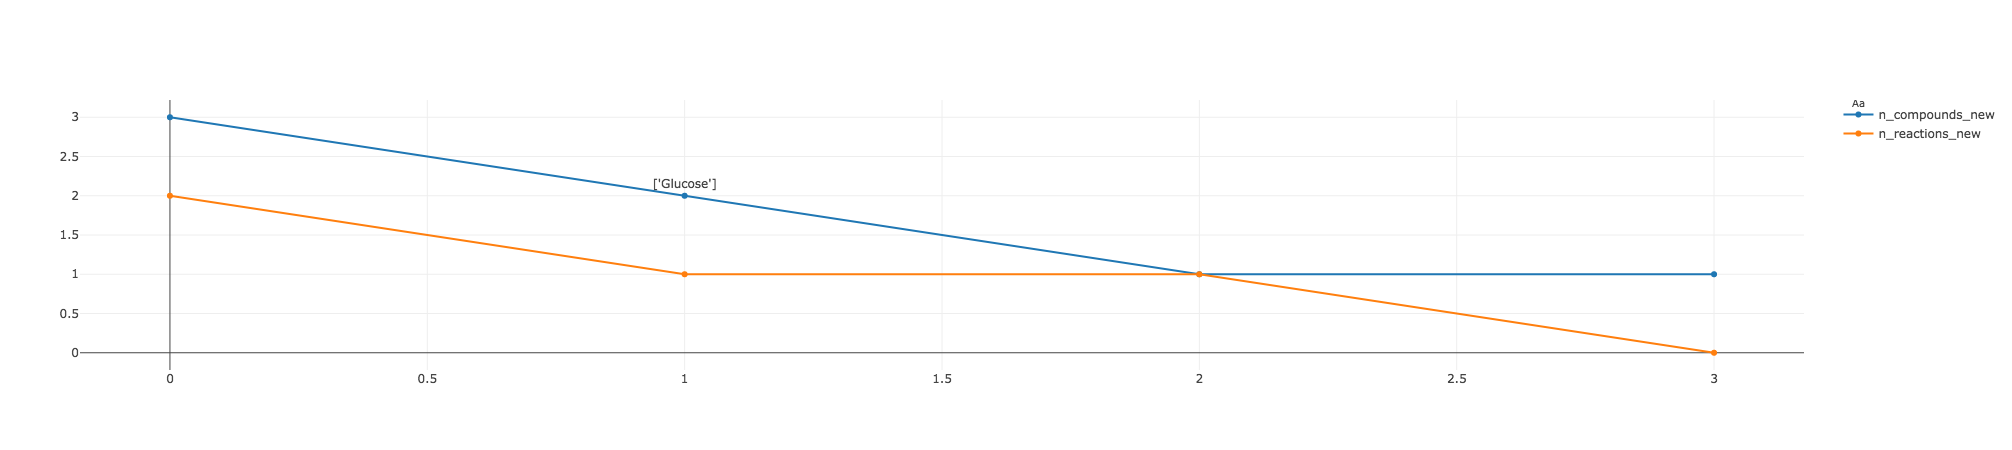

In [95]:
cool_plots(all_seed_dfs['Maltose_O2'],'n_compounds_new','n_reactions_new')

#### Test run

In [46]:
compounds_to_tag = {"C00003":'NAD',
                   "C00006":'NADP',
                   "C00002":'ATP',
                   "C00031":'Glucose',
                   "C00010":'CoA'}

In [48]:
seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
list_of_dicts = advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [51]:
glucose_df = pd.DataFrame(list_of_dicts)

In [52]:
glucose_df.head()

,bipartite_avg_betweenness_compounds,bipartite_avg_betweenness_reactions,bipartite_avg_clustering,bipartite_avg_clustering_compounds,bipartite_avg_clustering_reactions,bipartite_avg_deg_compounds,bipartite_avg_deg_reactions,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,0.388889,0.083333,0.750000,0.750000,0.750000,3.500000,1.750000,"[C00001, C00031]",0,2,2,4,4,"[R00307, R00306, R00028, R00010]","[C00001, C00031]",['C00031']
1,0.229167,0.051263,0.405139,0.219766,0.466930,6.000000,2.000000,"[C00185, C01083, C00095, C00208]",1,6,4,18,14,"[R00026, R02887, R09995, R00801, R10817, R0519...","[C00001, C00031]",None
2,0.072944,0.026941,0.241998,0.133498,0.294857,5.210526,2.538462,"[C00159, C06468, C06219, C00221, C00267, C0008...",2,19,13,39,21,"[R10809, R01519, R01332, R01823, R00015, R0210...","[C00001, C00031]",None
3,0.045824,0.025422,0.217042,0.149991,0.260770,4.300000,2.804348,"[C00252, C02336, C00257, C01742, C02492, C0366...",3,30,11,46,7,"[R11788, R01538, R11790, R08612, R03802, R1130...","[C00001, C00031]",None
4,0.038721,0.022192,0.211131,0.148474,0.252902,4.277778,2.851852,"[C06218, C21655, C17207, C00372, C00204, C21659]",4,36,6,54,8,"[R11789, R08614, R08570, R02120, R01540, R0212...","[C00001, C00031]",None


In [68]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

In [69]:
cool_plots(glucose_df,'n_compounds_new','n_reactions_new')

NameError: name 'glucose_df' is not defined

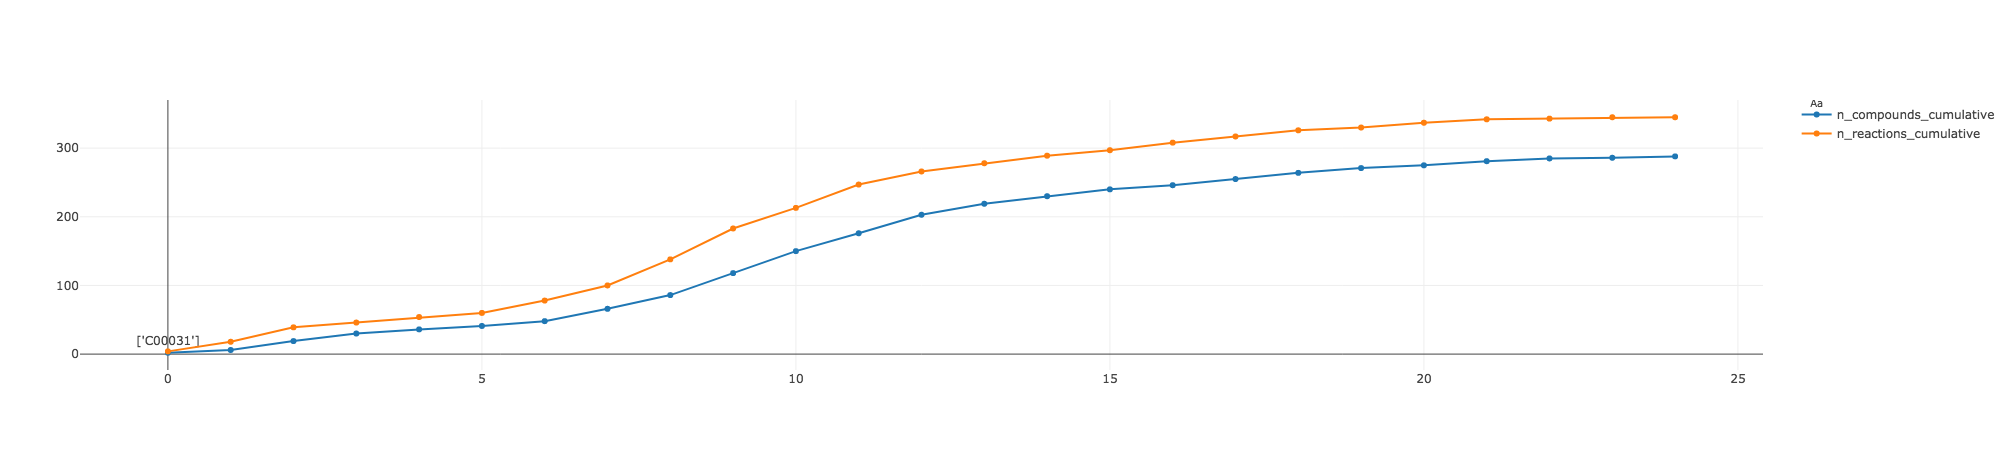

In [70]:
cool_plots(glucose_df,'n_compounds_cumulative','n_reactions_cumulative')

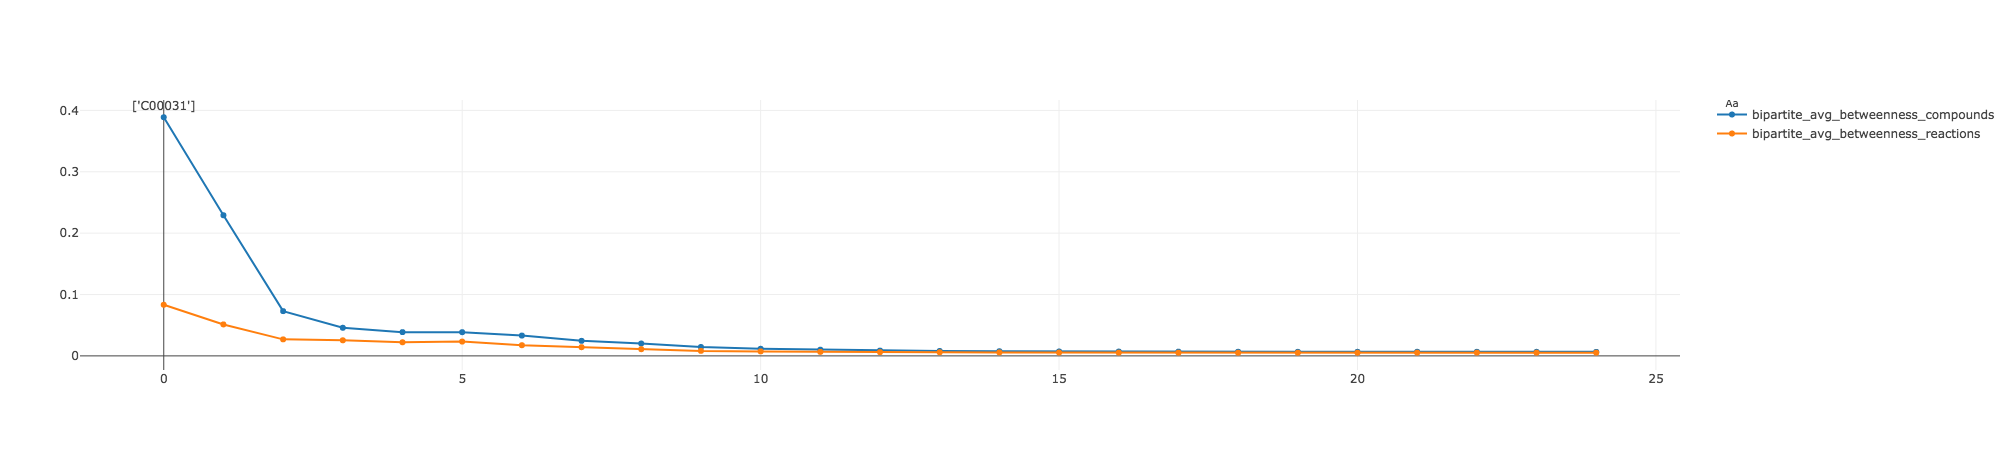

In [71]:
cool_plots(glucose_df,'bipartite_avg_betweenness_compounds','bipartite_avg_betweenness_reactions')

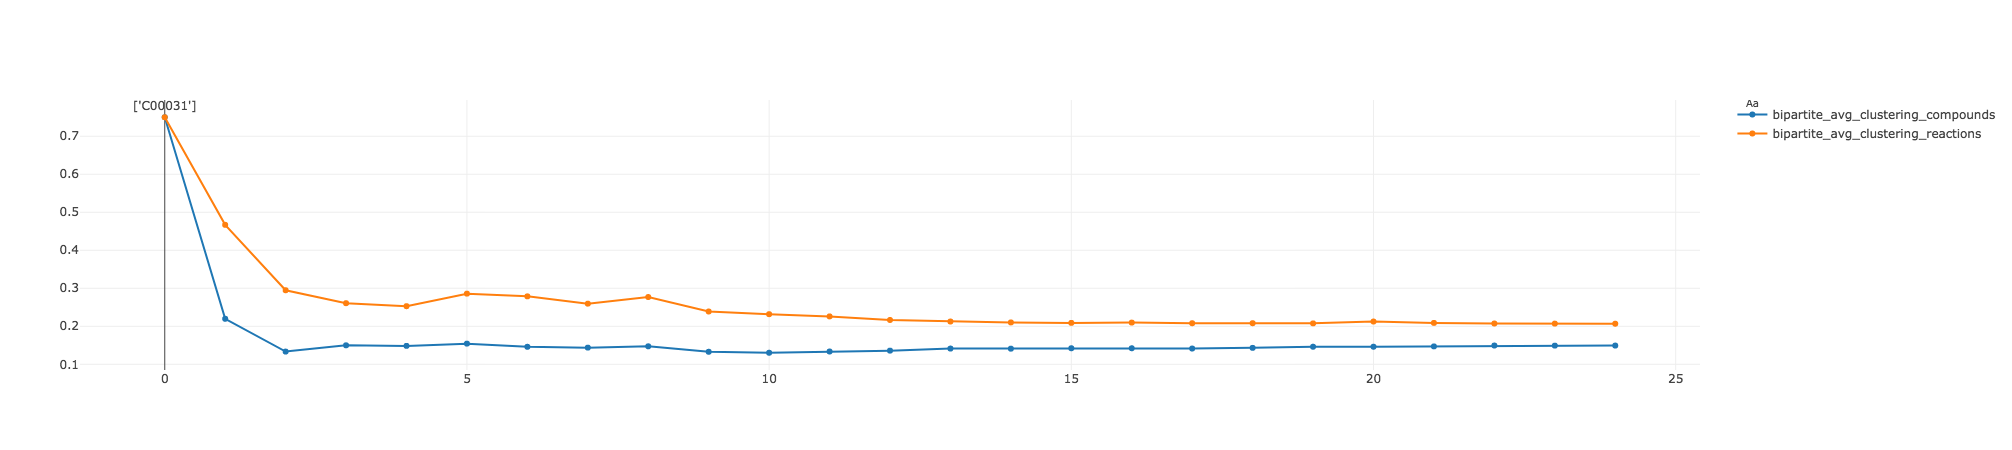

In [72]:
cool_plots(glucose_df,'bipartite_avg_clustering_compounds','bipartite_avg_clustering_reactions')

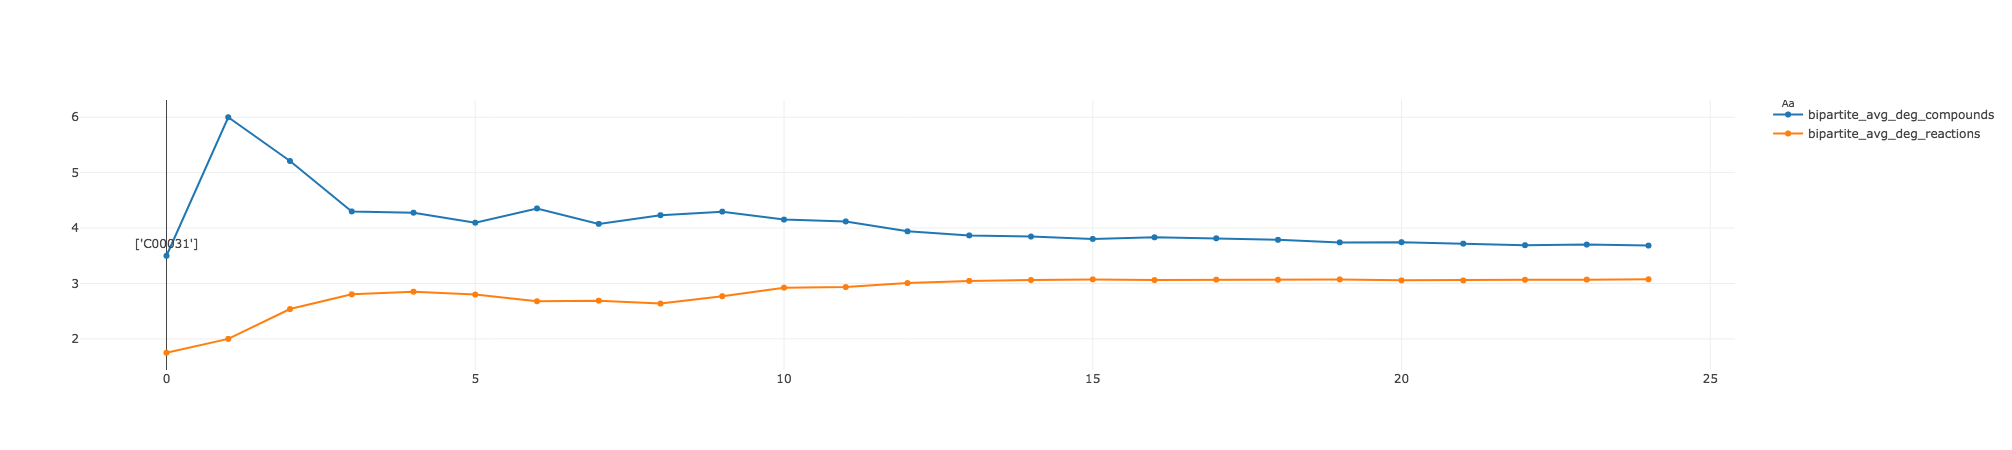

In [73]:
cool_plots(glucose_df,'bipartite_avg_deg_compounds','bipartite_avg_deg_reactions')

In [110]:
all_seed_dicts = dict()
for k in all_seeds:
    single_dict = advance_expansion_to_complete_scope(G,all_seeds[k],compounds_to_tag)
    all_seed_dicts[k] = single_dict

0
1
2
3
4
5
6
7
8
9


KeyError: u'C21593'

#### Test plotting

In [63]:
df_total = pd.DataFrame(gen_by_gen)
df_pergen = pd.DataFrame(added_per_gen)

NameError: name 'gen_by_gen' is not defined

In [107]:
df_total.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
n_compounds,2,6,19,30,36,41,48,66,86,118,...,240,246,255,264,271,275,281,285,286,288
n_reactions,4,18,39,46,54,60,78,100,138,183,...,297,308,317,326,330,337,342,343,345,345


In [108]:
df_pergen.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
n_compounds,2,4,13,11,6,5,7,18,20,32,...,10,6,9,9,7,4,6,4,1,2
n_reactions,4,14,21,7,8,6,18,22,38,45,...,8,11,9,9,4,7,5,1,2,0


In [109]:
df_pergen = df_pergen.transpose()

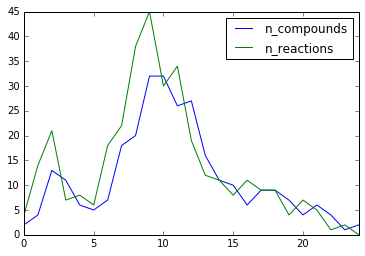

In [110]:
df_pergen.plot()

In [60]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
plotly.offline.init_notebook_mode(connected=True) 

In [61]:
plotly.__version__

'2.1.0'

In [129]:
list(df_pergen['n_compounds'])

[2,
 4,
 13,
 11,
 6,
 5,
 7,
 18,
 20,
 32,
 32,
 26,
 27,
 16,
 11,
 10,
 6,
 9,
 9,
 7,
 4,
 6,
 4,
 1,
 2]

In [62]:
# Create traces
trace0 = go.Scatter(
    x = df_pergen.index,
    y = list(df_pergen['n_compounds']),
    mode = 'lines+markers',
    name = 'compounds',
    text=['Text D', 'Text E', 'Text F']
#     text= data['state']
)
trace1 = go.Scatter(
    x = list(df_pergen.index),
    y = list(df_pergen['n_reactions']),
    mode = 'lines+markers',
    name = 'reactions'
)

data = [trace0,trace1]
plotly.offline.iplot(data)

NameError: name 'df_pergen' is not defined

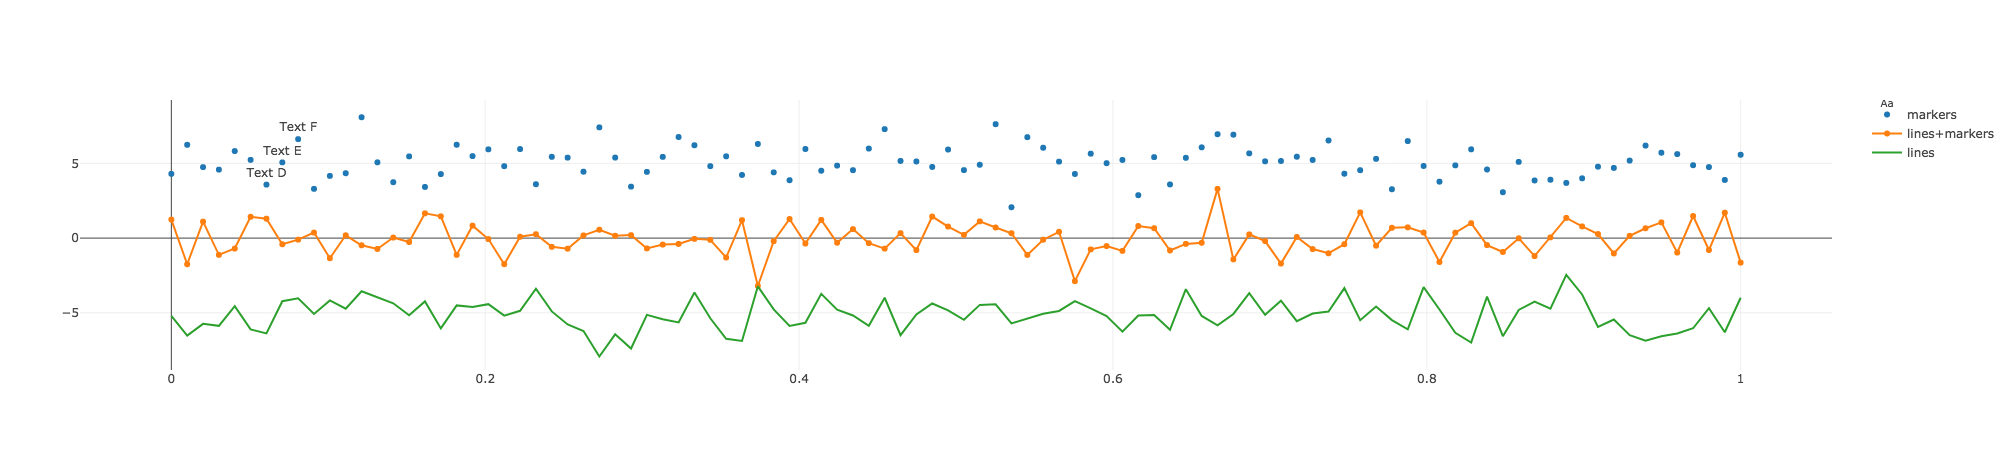

In [64]:
N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers+text',
    name = 'markers',
    text=[None,None,None,None,None,None,'Text D', 'Text E', 'Text F'],
    textposition='top'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'lines'
)

data = [trace0, trace1, trace2]
plotly.offline.iplot(data)

Need columns for:
- generation
- value (either n_compounds or n_reactions)
- seed_compound

In [80]:
df = df.transpose()

In [90]:
df.head()

,n_compounds,n_reactions
0,2,4
1,6,18
2,19,39
3,30,46
4,36,54


In [97]:
df2 = df.reset_index()

In [98]:
df2.head()

,index,n_compounds,n_reactions
0,0,2,4
1,1,6,18
2,2,19,39
3,3,30,46
4,4,36,54


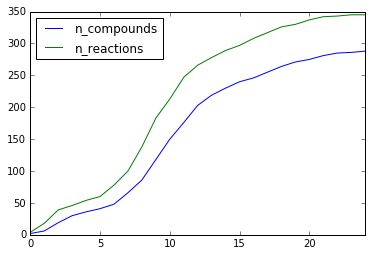

In [103]:
df.plot()

In [102]:
# df.plot()
# df2.plot(kind='scatter',x="index",y='n_compounds')
# df2.plot(kind='scatter',x="index",y='n_reactions',color="green")

# # df.plot(kind='scatter', x='a', y='b',
# #    ....:              color='DarkBlue', label='Group 1');

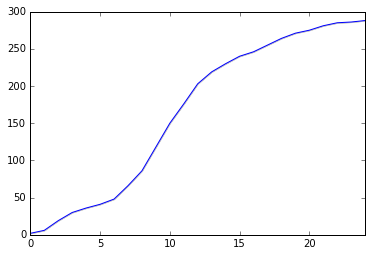

In [85]:
sns.tsplot(df['n_compounds'])

In [62]:
seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
verified_new_compounds,verified_new_reactions = advance_expansion_1_generation(G,seed_compounds,set())

In [63]:
verified_new_compounds

{u'C00095', u'C00185', u'C00208', u'C01083'}

In [64]:
verified_reactions

{u'R00010', u'R00028', u'R00306', u'R00307'}

In [22]:
s = set(range(3))

In [23]:
bigset = set(range(10))

In [29]:
if s.issubset(bigset):
    print "it's in"

it's in


In [44]:
s

{0, 1, 2}

In [43]:
bigset

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
bigset.difference_update()

In [27]:
s in bigset

False

In [28]:
s <= bigset

True

In [30]:
set(range(3)+range(5))

{0, 1, 2, 3, 4}

In [31]:
range(3)+range(5)

[0, 1, 2, 0, 1, 2, 3, 4]

In [ ]:
seed_compounds = (["C00001","C00031"]) # water and glucose (water is always a seed compound)